# Pneumonia Detection using Deep Learning

In [1]:
!wget https://dsserver-prod-resources-1.s3.amazonaws.com/cnn/xray_dataset.tar.gz

--2026-02-15 18:54:48--  https://dsserver-prod-resources-1.s3.amazonaws.com/cnn/xray_dataset.tar.gz
Resolving dsserver-prod-resources-1.s3.amazonaws.com (dsserver-prod-resources-1.s3.amazonaws.com)... 16.182.67.193, 3.5.29.148, 16.15.202.142, ...
Connecting to dsserver-prod-resources-1.s3.amazonaws.com (dsserver-prod-resources-1.s3.amazonaws.com)|16.182.67.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1223407715 (1.1G) [application/x-gzip]
Saving to: ‘xray_dataset.tar.gz.2’

xray_dataset.tar.gz 100%[===================>]   1.14G  17.5MB/s    in 71s     

2026-02-15 18:56:00 (16.5 MB/s) - ‘xray_dataset.tar.gz.2’ saved [1223407715/1223407715]



In [2]:
import tarfile

def extract_tar_gz(file_path):
    with tarfile.open(file_path, 'r:gz') as tar:
        tar.extractall()
        print(f"Extraction of {file_path} complete.")

extract_tar_gz('xray_dataset.tar.gz')

/tmp/ipython-input-2096219887.py:5: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall()


Extraction of xray_dataset.tar.gz complete.


In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report, confusion_matrix

In [4]:
BATCH_SIZE = 64
IMAGE_SIZE = (256, 256)
VALIDATION_SPLIT = 0.2
DATA_DIR = 'chest_xray/train'

train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=VALIDATION_SPLIT,
    subset="training",
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary'
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=VALIDATION_SPLIT,
    subset="validation",
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary'
)

TEST_DIR = 'chest_xray/test'

test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary'
)

class_names = train_ds.class_names
print(f"Class names found: {class_names}")

Found 5232 files belonging to 2 classes.
Using 4186 files for training.
Found 5232 files belonging to 2 classes.
Using 1046 files for validation.
Found 624 files belonging to 2 classes.
Class names found: ['NORMAL', 'PNEUMONIA']


In [5]:
normalization_layer = layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

print("Datasets preprocessed and normalized successfully!")

Datasets preprocessed and normalized successfully!


/tmp/ipython-input-2571052918.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label_index = int(labels[i].numpy())


Batch Images Shape: (64, 256, 256, 3)
Batch Labels Shape: (64, 1)
Sample Label Values: [1. 0. 1. 0. 0. 1. 0. 1. 1.] (0 = Normal, 1 = Pneumonia)


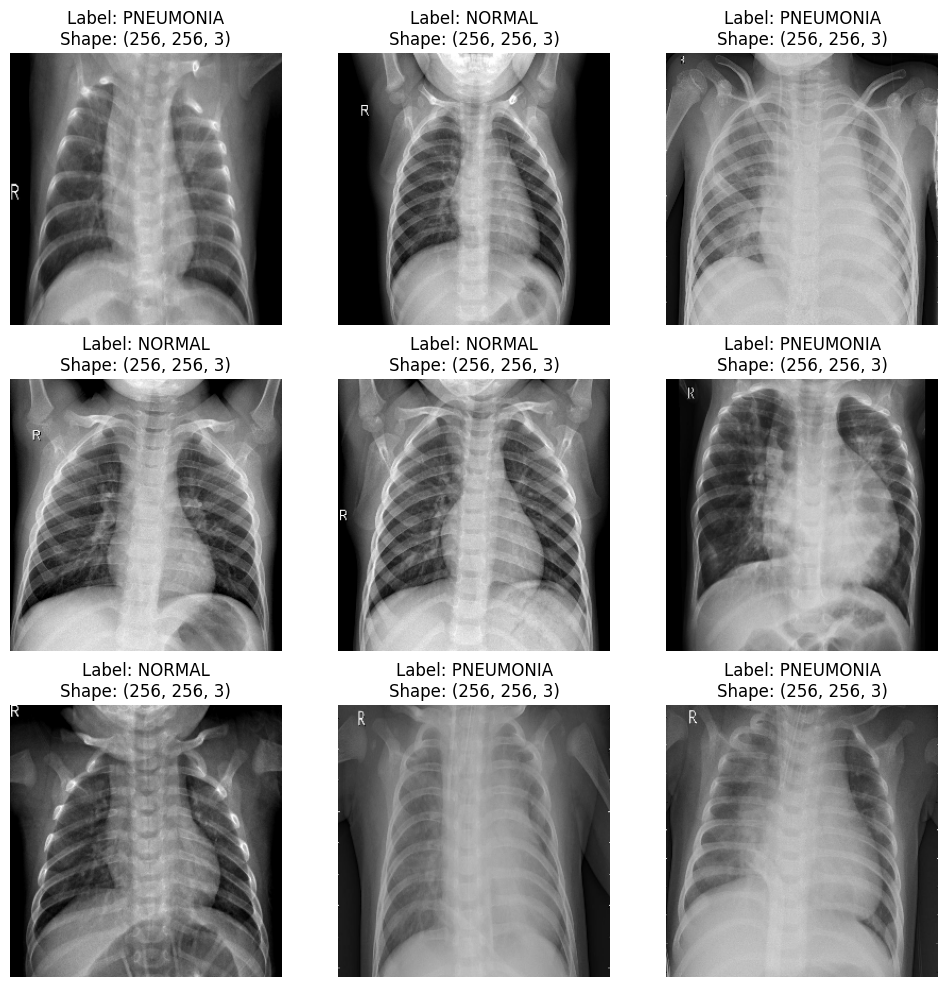

In [6]:
for images, labels in train_ds.take(1):
    plt.figure(figsize=(12, 12))

    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)

        plt.imshow(images[i].numpy())

        label_index = int(labels[i].numpy())
        label_name = class_names[label_index]

        plt.title(f"Label: {label_name}\nShape: {images[i].shape}")
        plt.axis("off")

    print(f"Batch Images Shape: {images.shape}")
    print(f"Batch Labels Shape: {labels.shape}")
    print(f"Sample Label Values: {labels[:9].numpy().flatten()} (0 = Normal, 1 = Pneumonia)")

# CNN Model

In [7]:
model = models.Sequential([
    layers.Input(shape=(256, 256, 3)),


    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),


    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),


    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),


    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    14,745,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,839,105 (56.61 MB)

 Trainable params: 14,839,105 (56.61 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]
)

In [9]:
EPOCHS = 10

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

Epoch 1/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 53s 599ms/step - accuracy: 0.7769 - loss: 0.6963 - precision: 0.8145 - recall: 0.9089 - val_accuracy: 0.9474 - val_loss: 0.1567 - val_precision: 0.9415 - val_recall: 0.9938
Epoch 2/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 31s 463ms/step - accuracy: 0.9522 - loss: 0.1487 - precision: 0.9590 - recall: 0.9783 - val_accuracy: 0.9694 - val_loss: 0.0902 - val_precision: 0.9924 - val_recall: 0.9679
Epoch 3/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 32s 479ms/step - accuracy: 0.9630 - loss: 0.1028 - precision: 0.9775 - recall: 0.9727 - val_accuracy: 0.9732 - val_loss: 0.0727 - val_precision: 0.9863 - val_recall: 0.9790
Epoch 4/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 36s 543ms/step - accuracy: 0.9650 - loss: 0.0904 - precision: 0.9780 - recall: 0.9750 - val_accuracy: 0.9579 - val_loss: 0.1052 - val_precision: 0.9506 - val_recall: 0.9975
Epoch 5/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 30s 459ms/step - accuracy: 0.9697 - loss: 0.0803 - precision: 0.9759 - recall: 0.9840 - val_accuracy: 0.9694 - val_los

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


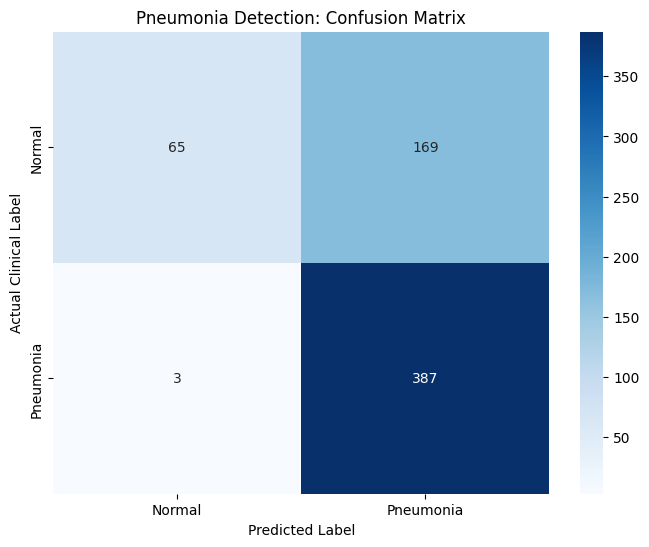


--- Classification Report ---
              precision    recall  f1-score   support

      Normal       0.96      0.28      0.43       234
   Pneumonia       0.70      0.99      0.82       390

    accuracy                           0.72       624
   macro avg       0.83      0.64      0.62       624
weighted avg       0.79      0.72      0.67       624



In [10]:
y_true = []
y_pred_probs = []

for images, labels in test_ds:
    y_true.extend(labels.numpy())
    preds = model.predict(images)
    y_pred_probs.extend(preds)

y_true = np.array(y_true).flatten()
y_pred = (np.array(y_pred_probs) > 0.5).astype("int32").flatten()

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Pneumonia'],
            yticklabels=['Normal', 'Pneumonia'])
plt.title('Pneumonia Detection: Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Clinical Label')
plt.show()

print("\n--- Classification Report ---")
print(classification_report(y_true, y_pred, target_names=['Normal', 'Pneumonia']))

# Transfer Learning

In [11]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(256, 256, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'Recall', 'Precision'])

/tmp/ipython-input-826959943.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(


In [12]:
def count_classes(dataset, name):
    normal = 0
    pneumonia = 0
    for _, labels in dataset:
        batch_labels = labels.numpy().flatten()
        pneumonia += np.sum(batch_labels == 1)
        normal += np.sum(batch_labels == 0)

    print(f"--- {name} Dataset ---")
    print(f"NORMAL: {int(normal)}")
    print(f"PNEUMONIA: {int(pneumonia)}")
    print(f"Total: {int(normal + pneumonia)}")
    return normal, pneumonia

train_n, train_p = count_classes(train_ds, "Training (80%)")
print("")
val_n, val_p = count_classes(val_ds, "Validation (20%)")

--- Training (80%) Dataset ---
NORMAL: 1113
PNEUMONIA: 3073
Total: 4186

--- Validation (20%) Dataset ---
NORMAL: 236
PNEUMONIA: 810
Total: 1046


In [13]:
counts_normal = 1113
counts_pneumonia = 3073

weight_for_0 = (1 / counts_normal) * (counts_normal + counts_pneumonia) / 2.0
weight_for_1 = (1 / counts_pneumonia) * (counts_normal + counts_pneumonia) / 2.0

class_weights = {0: weight_for_0, 1: weight_for_1}


history = model.fit(train_ds, validation_data=val_ds, epochs=10, class_weight=class_weights)

Epoch 1/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 86s 939ms/step - Precision: 0.9312 - Recall: 0.8514 - accuracy: 0.8406 - loss: 0.3499 - val_Precision: 0.9949 - val_Recall: 0.9543 - val_accuracy: 0.9608 - val_loss: 0.1114
Epoch 2/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 35s 532ms/step - Precision: 0.9886 - Recall: 0.9503 - accuracy: 0.9549 - loss: 0.1173 - val_Precision: 0.9950 - val_Recall: 0.9753 - val_accuracy: 0.9771 - val_loss: 0.0756
Epoch 3/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 30s 460ms/step - Precision: 0.9916 - Recall: 0.9594 - accuracy: 0.9635 - loss: 0.0876 - val_Precision: 0.9986 - val_Recall: 0.9099 - val_accuracy: 0.9293 - val_loss: 0.1767
Epoch 4/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 31s 475ms/step - Precision: 0.9909 - Recall: 0.9632 - accuracy: 0.9656 - loss: 0.0889 - val_Precision: 0.9987 - val_Recall: 0.9395 - val_accuracy: 0.9522 - val_loss: 0.1272
Epoch 5/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 30s 462ms/step - Precision: 0.9931 - Recall: 0.9697 - accuracy: 0.9720 - loss: 0.0725 - val_Precision: 0.9987 - val_Re

2/2 ━━━━━━━━━━━━━━━━━━━━ 16s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step


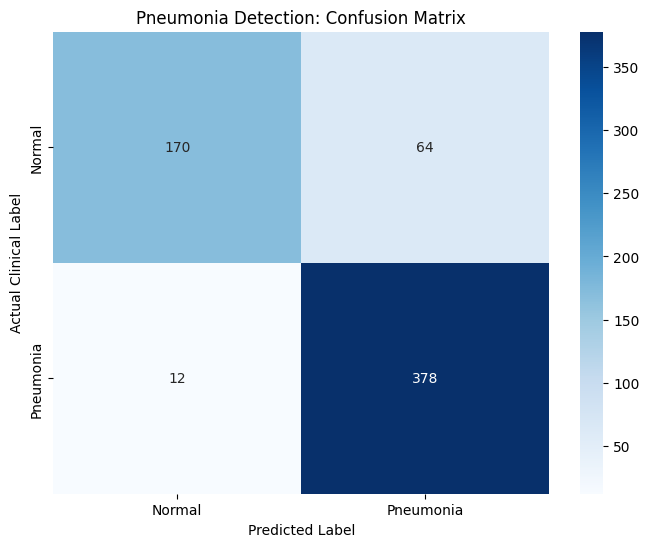


--- Classification Report ---
              precision    recall  f1-score   support

      Normal       0.93      0.73      0.82       234
   Pneumonia       0.86      0.97      0.91       390

    accuracy                           0.88       624
   macro avg       0.89      0.85      0.86       624
weighted avg       0.88      0.88      0.87       624



In [14]:
y_true = []
y_pred_probs = []

for images, labels in test_ds:
    y_true.extend(labels.numpy())
    preds = model.predict(images)
    y_pred_probs.extend(preds)

y_true = np.array(y_true).flatten()
y_pred = (np.array(y_pred_probs) > 0.5).astype("int32").flatten()

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Pneumonia'],
            yticklabels=['Normal', 'Pneumonia'])
plt.title('Pneumonia Detection: Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Clinical Label')
plt.show()

print("\n--- Classification Report ---")
print(classification_report(y_true, y_pred, target_names=['Normal', 'Pneumonia']))

# Prediction

In [19]:
from google.colab import files
from tensorflow.keras.preprocessing import image

def predict_xray(img_path):
    img = image.load_img(img_path, target_size=(256, 256))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    prediction = model.predict(img_array)

    if prediction[0] > 0.5:
        print(f"Prediction: PNEUMONIA ({prediction[0][0]*100:.2f}%)")
    else:
        print(f"Prediction: NORMAL ({(1-prediction[0][0])*100:.2f}%)")

In [20]:
predict_xray('/content/chest_xray/test/NORMAL/IM-0001-0001.jpeg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
Prediction: NORMAL (99.97%)
